## TEM image analysis
___

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import threshold_otsu, threshold_adaptive
from skimage.color import rgb2gray, label2rgb
from skimage import data,io,filters,measure,img_as_ubyte,segmentation
import skimage

In [96]:
%matplotlib inline

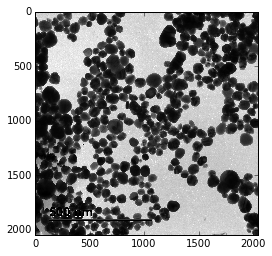

In [97]:
orig = io.imread('AgNP-12.tif')
imggray = rgb2gray(orig)
fig = plt.figure()
plt.gray()
plt.imshow(imggray)

In [1]:
otsu = threshold_otsu(imggray)
imgotsu = imggray > otsu
imgotsuinv = np.invert(imgotsu)

plt.figure(figsize=(10,8))
plt.imshow(imgotsuinv)

NameError: name 'threshold_otsu' is not defined

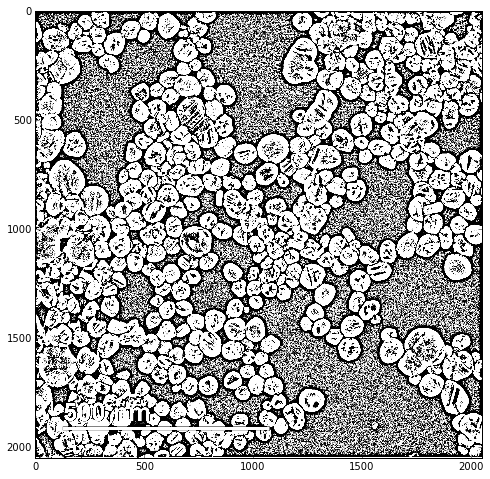

In [120]:
BlockSize = 41
imgadpt = threshold_adaptive(imggray,BlockSize,offset=0)
imginv = np.invert(img_as_ubyte(imgadpt))

plt.figure(figsize=(10,8))
plt.gray()
plt.imshow(imginv)

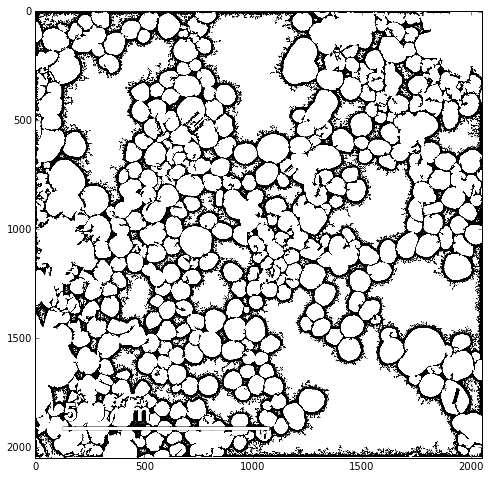

In [121]:
from skimage.morphology import binary_dilation, closing
from scipy import ndimage as ndi
imgfill = ndi.binary_fill_holes(imginv)

plt.figure(figsize=(10,8))
plt.gray()
plt.imshow(imgfill)

(-0.5, 2047.5, 2047.5, -0.5)

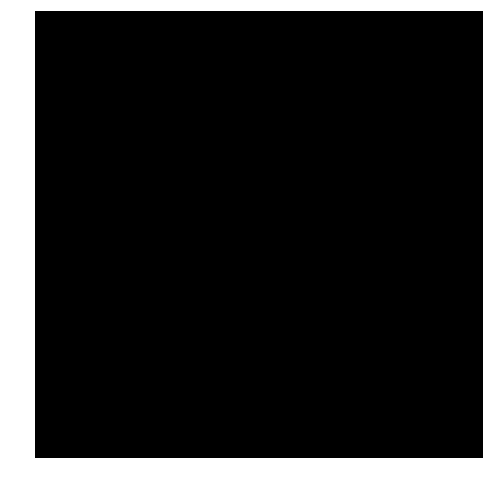

In [160]:
from skimage.feature import canny
edges = canny(imggray/255.)

fig, ax = plt.subplots(figsize=(10,8))
ax.axis('off')
ax.imshow(edges, cmap=plt.cm.gray, interpolation='nearest')

Number of regions: 7985


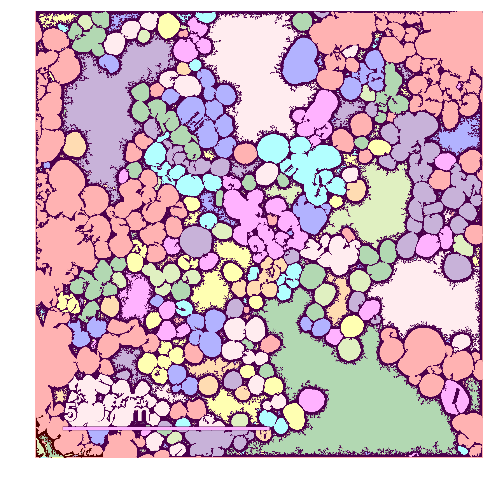

In [144]:
imgndilbl, numlbls = measure.label(imgfill, connectivity=2, return_num=True)
imgoverlay = label2rgb(imgndilbl, image=imgfill)

print("Number of regions: "+str(numlbls))

plt.figure(figsize=(10,8))
plt.axis('off')
axes = plt.imshow(imgoverlay)

In [146]:
regions = measure.regionprops(imgndilbl)

# Find labels with desired eccentricity and area

ecc = []
area = []
solid = []
extent = []
for i in range(len(regions)):
    ecc.append(regions[i].eccentricity)
    area.append(regions[i].area)
    solid.append(regions[i].solidity)
    extent.append(regions[i].extent)

In [158]:
ds = list(zip(ecc,area,solid,extent))
cols = ['Ecc','Area','Solidity', 'Extent']
df = pd.DataFrame(ds, columns=cols)

nps = df[(df.Ecc<0.8) & (df.Area>1) & (df.Extent<0.5)] # & (df.Ecc>0)]

print("Identified NPs:", len(nps))
print(min(extent), max(extent))

Identified NPs: 175
0.126373626374 1.0


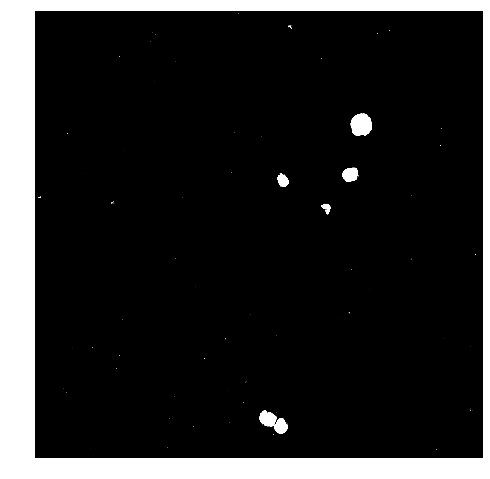

In [159]:
# Select the labels found in the previous cell

mask = np.in1d(imgndilbl.flatten(),nps.index)

select = imgndilbl*mask.reshape(imgndilbl.shape)
# set(select.flatten().tolist())

select.max(), select.shape

# Plot the labels found above

imgselect = label2rgb(select, image=imgfill)



plt.figure(figsize=(10,8))
plt.axis('off')
axes = plt.imshow(select>0)

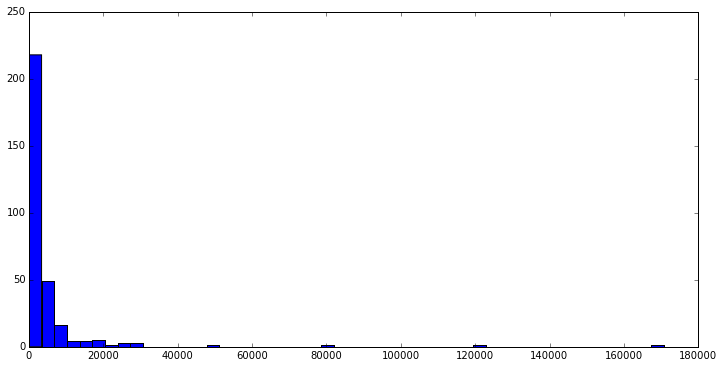

In [137]:
npareas = nps.Area.tolist()
plt.figure(figsize=(12,6))
n,bins,patches = plt.hist(npareas, bins=50)